In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from datetime import datetime
from copy import deepcopy
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import GaussianBlur
import lovely_tensors as lt
from nnfabrik.builder import get_data

import csng
from csng.InvertedEncoder import InvertedEncoder
from csng.utils import crop, plot_comparison, standardize, normalize, get_mean_and_std, count_parameters
from csng.losses import SSIMLoss, Loss
from csng.data import MixedBatchLoader

from csng.comparison import get_metrics, load_decoder_from_ckpt
from csng.mouse_v1.encoder import get_encoder
from csng.mouse_v1.data_utils import get_mouse_v1_data, PerSampleStoredDataset
from csng.mouse_v1.cnn_decoder_utils import get_all_data

lt.monkey_patch()

DATA_PATH = os.path.join(os.environ["DATA_PATH"], "mouse_v1_sensorium22")
print(f"{DATA_PATH=}")

/home/sobotj11/miniconda3/envs/dev/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


DATA_PATH='/home/sobotj11/decoding-brain-activity/data/mouse_v1_sensorium22'


In [2]:
config = {
    "data": {
        "mixing_strategy": "parallel_min", # needed only with multiple base dataloaders
    },
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 0,
    "crop_win": (22, 36),
}

print(f"... Running on {config['device']} ...")

... Running on cuda ...


In [3]:
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
random.seed(config["seed"])

## Encoder Inversion

#### Data

In [ ]:
### prep data config
config["data"]["mouse_v1"] = {
    "dataset_fn": "sensorium.datasets.static_loaders",
    "dataset_config": {
        "paths": [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
            # os.path.join(DATA_PATH, "static26872-17-20-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # mouse 1
            # os.path.join(DATA_PATH, "static27204-5-13-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # sensorium+ (mouse 2)
            os.path.join(DATA_PATH, "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 3)
            # os.path.join(DATA_PATH, "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 4)
            # os.path.join(DATA_PATH, "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 5)
            # os.path.join(DATA_PATH, "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 6)
            # os.path.join(DATA_PATH, "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 7)
        ],
        "normalize": True,
        "scale": 0.25, # 256x144 -> 64x36
        "include_behavior": False,
        "add_behavior_as_channels": False,
        "include_eye_position": True,
        "exclude": None,
        "file_tree": True,
        "cuda": "cuda" in config["device"],
        "batch_size": 512,
        "seed": config["seed"],
        "use_cache": False,
    },
    "skip_train": False,
    "skip_val": False,
    "skip_test": False,
    "normalize_neuron_coords": True,
    "average_test_multitrial": True,
    "save_test_multitrial": True,
    "test_batch_size": 7,
    "device": config["device"],
}

### get dataloaders and cell coordinates
dataloaders, neuron_coords = get_mouse_v1_data(config["data"])

In [ ]:
### show data
sample_data_key = dataloaders["mouse_v1"]["test"].data_keys[0]
datapoint = next(iter(dataloaders["mouse_v1"]["test"].dataloaders[0]))
stim, resp = datapoint.images, datapoint.responses
pupil_center = datapoint.pupil_center
print(
    f"Training dataset:\t {sum(len(dl) * dl.batch_size for dl in dataloaders['mouse_v1']['train'].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * dl.batch_size for dl in dataloaders['mouse_v1']['val'].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * dl.batch_size for dl in dataloaders['mouse_v1']['test'].dataloaders)} samples"
    f"\nTest (no resp) dataset:\t {sum(len(dl) * dl.batch_size for dl in dataloaders['mouse_v1']['test_no_resp'].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {stim.shape}"
    f"\n  min={stim.min().item():.3f}  max={stim.max().item():.3f}"
    f"\n  mean={stim.mean().item():.3f}  std={stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {resp.shape}"
    f"\n  min={resp.min().item():.3f}  max={resp.max().item():.3f}"
    f"\n  mean={resp.mean().item():.3f}  std={resp.std().item():.3f}"
    "\nneuronal coordinates:"
    f"\n  {neuron_coords[sample_data_key].shape}"
    f"\n  min={neuron_coords[sample_data_key].min():.3f}  max={neuron_coords[sample_data_key].max():.3f}"
    f"\n  mean={neuron_coords[sample_data_key].mean():.3f}  std={neuron_coords[sample_data_key].std():.3f}"
)

### plot sample data
sample_idx = 0

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(131)
ax.imshow(stim[sample_idx].squeeze().unsqueeze(-1).cpu(), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(stim[sample_idx].cpu(), config["crop_win"]).squeeze().unsqueeze(-1), cmap="gray")

### bin the neuronal responses based on their neuron coordinates and sum within each bin -> 2D grid of vals
coords = neuron_coords[sample_data_key]
H, W = stim.shape[-2:] # the size of the grid
n_x_bins, n_y_bins = 32, 18 # number of bins in each dimension
min_x, max_x, min_y, max_y = coords[:,0].min().item(), coords[:,0].max().item(), coords[:,1].min().item(), coords[:,1].max().item()
x_bins = torch.linspace(min_x, max_x, n_x_bins + 1)
y_bins = torch.linspace(min_y, max_y, n_y_bins + 1)
binned_resp = torch.zeros(n_y_bins, n_x_bins)
for i in range(n_y_bins):
    for j in range(n_x_bins):
        ### mask of the neurons in the bin
        mask = (x_bins[j] <= coords[:,0]) &\
               (coords[:,0] < x_bins[j + 1]) &\
               (y_bins[i] <= coords[:,1]) &\
               (coords[:,1] < y_bins[i + 1])
        binned_resp[i,j] = resp[sample_idx, mask.cpu()].sum(0)
ax = fig.add_subplot(133)
ax.imshow(binned_resp.squeeze().cpu(), cmap="gray")
plt.show()

#### Load Encoder

In [ ]:
encoder = get_encoder(ckpt_path=os.path.join(DATA_PATH, "models", "encoder_sens22.pth"), device=config["device"], eval_mode=True)

In [ ]:
### load encoder
print("Loading encoder...")

from lurz2020.models.models import se2d_fullgaussian2d

### load pretrained encoder ckpt
encoder_ckpt = torch.load(
    os.path.join(DATA_PATH, "models", "encoder.pt"),
    map_location=config["device"],
)

### get temporary dataloaders for the encoder
_dataloaders = get_data(
    encoder_ckpt["config"]["data"]["dataset_fn"],
    encoder_ckpt["config"]["data"]["dataset_config"]
)

### init encoder
encoder = se2d_fullgaussian2d(
    **encoder_ckpt["config"]["encoder"]["model_config"],
    dataloaders=_dataloaders,
    seed=encoder_ckpt["config"]["seed"],
).float()
encoder.load_state_dict(encoder_ckpt["encoder_state"], strict=True)
encoder.to(config["device"])
encoder.eval()
del _dataloaders

#### Run Inversion

In [ ]:
def plot_loss_history(history):
    fig = plt.figure(figsize=(16, 6))
    ax = fig.add_subplot(121)
    ax.plot(history["resp_loss"])
    ax.set_title("resp_loss")

    ax = fig.add_subplot(122)
    ax.plot(history["stim_loss"])
    ax.set_title("stim_loss")
    plt.show()

In [ ]:
### set targets
target_stim = stim.float().to(config["device"])
target_resp = resp.float().to(config["device"])
target_pupil_center = pupil_center.float().to(config["device"])
data_key = sample_data_key

In [ ]:
### config
config["enc_inv"] = {
    "encoder": encoder,
    "img_dims": stim.shape[1:],
    "stim_pred_init": "zeros",
    "opter_cls": torch.optim.SGD,
    "opter_config": {"lr": 1500, "momentum": 0.},
    "n_steps": 400,
    "resp_loss_fn": F.mse_loss,
    "stim_loss_fn": SSIMLoss(
        window=config["crop_win"],
        log_loss=True,
        inp_normalized=True,
        inp_standardized=False,
    ),
    "img_gauss_blur_config": None,
    "img_grad_gauss_blur_config": {"kernel_size": 17, "sigma": 2},
    "device": config["device"],
}

In [ ]:
config["enc_inv"]["img_grad_gauss_blur_config"]

In [ ]:
model = InvertedEncoder(**config["enc_inv"]).to(config["device"])
stim_pred, _, history = model(
    resp_target=target_resp,
    stim_target=target_stim,
    additional_encoder_inp={
        "data_key": data_key,
        "pupil_center": target_pupil_center,
    }
)
stim_pred_best = history["best"]["stim_pred"]

### show the results
print(history["best"]["stim_loss"])
plot_loss_history(history)
stim_pred_best = history["best"]["stim_pred"]
plot_comparison(target=crop(target_stim[:8], config["crop_win"]).cpu(), pred=crop(stim_pred[:8], config["crop_win"]).detach().cpu())
plot_comparison(target=crop(target_stim[:8], config["crop_win"]).cpu(), pred=crop(stim_pred_best[:8], config["crop_win"]).detach().cpu(), pred_title="Reconstructed (best)");

#### Hyperparam search

In [ ]:
### hyperparam configs
config_updates = [
    {"opter_config": {"lr": 1000}, "img_grad_gauss_blur_config": dict(kernel_size=11, sigma=2.)},
    {"opter_config": {"lr": 1000}, "img_grad_gauss_blur_config": dict(kernel_size=13, sigma=2.)},
    {"opter_config": {"lr": 1000}, "img_grad_gauss_blur_config": dict(kernel_size=15, sigma=2.)},

    {"opter_config": {"lr": 500}, "img_grad_gauss_blur_config": dict(kernel_size=13, sigma=2.5)},
    {"opter_config": {"lr": 500}, "img_grad_gauss_blur_config": dict(kernel_size=15, sigma=2.5)},
    {"opter_config": {"lr": 500}, "img_grad_gauss_blur_config": dict(kernel_size=17, sigma=2.5)},
    {"opter_config": {"lr": 500}, "img_grad_gauss_blur_config": dict(kernel_size=21, sigma=2.5)},

    {"opter_config": {"lr": 1000, "momentum": 0}, "img_grad_gauss_blur_config": dict(kernel_size=15, sigma=2.5)},
    {"opter_config": {"lr": 1000, "momentum": 0}, "img_grad_gauss_blur_config": dict(kernel_size=17, sigma=2.5)},
]

In [ ]:
### run
results = []
for i, config_update in enumerate(config_updates):
    print(f"[{i+1}/{len(config_updates)}]")
    run_config = deepcopy(config)
    run_config["enc_inv"].update(config_update)
    model = InvertedEncoder(**run_config["enc_inv"]).to(config["device"])
    stim_pred, _, history = model(
        resp_target=target_resp,
        stim_target=target_stim,
        additional_encoder_inp={
            "data_key": data_key,
            "pupil_center": target_pupil_center,
        }
    )
    stim_pred_best = history["best"]["stim_pred"]
    results.append({"run_config": run_config, "stim_pred": stim_pred, "history": history})

In [ ]:
for r in results:
    print(
        f"lr={r['run_config']['enc_inv']['opter_config']['lr']}"
        f", sigma={r['run_config']['enc_inv']['img_grad_gauss_blur_config']['sigma']}"
        f", ker_sz={r['run_config']['enc_inv']['img_grad_gauss_blur_config']['kernel_size']}"
        f"   {r['history']['best']['stim_loss']:.5f}"
    )

    ### plot loss history
    plot_loss_history(history=r["history"])

    ### plot best results
    plot_comparison(target=crop(target_stim[:8], config["crop_win"]).cpu(),
                    pred=crop(r['history']['best']['stim_pred'][:8], config["crop_win"]).cpu())

#### Testing

In [ ]:
from comparison_utils import get_metrics

In [ ]:
### Encoder inversion config
config["enc_inv"] = {
    "model": {
        "encoder": get_encoder(
            ckpt_path=os.path.join(DATA_PATH, "models", "encoder_sens22.pth"),
            device=config["device"],
            eval_mode=True,
            # ckpt_path=os.path.join(DATA_PATH, "models", "encoder_sens22_no_shifter.pth"),
        ),
        "img_dims": (1, 36, 64),
        "stim_pred_init": "zeros",
        "opter_cls": torch.optim.SGD,
        "opter_config": {"lr": 150, "momentum": 0.},
        "n_steps": 400,
        "resp_loss_fn": lambda resp_pred, resp_target: F.mse_loss(resp_pred, resp_target, reduction="none").mean(-1).sum(),
        "stim_loss_fn": None, # set below
        "img_gauss_blur_config": None,
        "img_grad_gauss_blur_config": {"kernel_size": 13, "sigma": 2.},
        "device": config["device"],
    },
    "loss_fns": get_metrics(config=config),
    "save_dir": os.path.join(DATA_PATH, "models", "inverted_encoder"),
    # "find_best_ckpt_according_to": "Perceptual Loss (VGG16)",
    "find_best_ckpt_according_to": "SSIML + PSL",
}
config["enc_inv"]["model"]["stim_loss_fn"] = config["enc_inv"]["loss_fns"][config["enc_inv"]["find_best_ckpt_according_to"]]
model = InvertedEncoder(**config["enc_inv"]["model"]).to(config["device"])

In [ ]:
config["enc_inv"]["model"]["n_steps"] = 500
config["enc_inv"]["model"]["img_grad_gauss_blur_config"] = {"kernel_size": 13, "sigma": 2.}
config["enc_inv"]["model"]["opter_config"] = {"lr": 500, "momentum": 0.}
model = InvertedEncoder(**config["enc_inv"]["model"]).to(config["device"])

In [ ]:
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
random.seed(config["seed"])
stim_pred, _, hist = model(
    resp_target=resp[:128],
    stim_target=stim[:128],
    additional_encoder_inp={
        "data_key": sample_data_key,
        "pupil_center": pupil_center[:128],
    }
)

In [ ]:
from csng.losses import SSIM
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM2

In [ ]:
ssim = SSIM(size_average=False)
ssim2 = SSIM2(reduction="none")

In [ ]:
ssim(standardize(stim_pred), standardize(stim)[:128]), ssim2(standardize(stim_pred), standardize(stim)[:128])

In [ ]:
ssim(stim_pred, stim[:128]), ssim2(stim_pred, stim[:128])

In [ ]:
_ = plot_comparison(target=crop(stim[:8], config["crop_win"]).cpu(), pred=crop(stim_pred[:8], config["crop_win"]).cpu())
plt.plot(hist["stim_loss"], label="stim_loss")
plt.plot(hist["resp_loss"], label="resp_loss")
plt.legend()

## Test code from EGG

### Data

In [4]:
config["crop_win"] = (22, 36)
config["data"] = dict(mixing_strategy="sequential")

### mouse v1 data
config["data"]["mouse_v1"] = {
    "dataset_fn": "sensorium.datasets.static_loaders",
    "dataset_config": {
        "paths": [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
            # os.path.join(DATA_PATH, "static26872-17-20-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # mouse 1
            # os.path.join(DATA_PATH, "static27204-5-13-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # sensorium+ (mouse 2)
            os.path.join(DATA_PATH, "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 3)
            # os.path.join(DATA_PATH, "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 4)
            # os.path.join(DATA_PATH, "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 5)
            # os.path.join(DATA_PATH, "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 6)
            # os.path.join(DATA_PATH, "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 7)
        ],
        "normalize": True,
        "scale": 0.25, # 256x144 -> 64x36
        "include_behavior": False,
        "add_behavior_as_channels": False,
        "include_eye_position": True,
        "exclude": None,
        "file_tree": True,
        "cuda": "cuda" in config["device"],
        "batch_size": 8,
        "seed": config["seed"],
        "use_cache": False,
    },
    "skip_train": False,
    "skip_val": False,
    "skip_test": False,
    "normalize_neuron_coords": True,
    "average_test_multitrial": True,
    "save_test_multitrial": True,
    "test_batch_size": 7,
    "device": config["device"],
}

### sample data
dls, neuron_coords = get_all_data(config=config)
sample_data_key = dls["mouse_v1"]["val"].data_keys[0]
datapoint = next(iter(dls["mouse_v1"]["val"].dataloaders[0]))
stim, resp, pupil_center = datapoint.images, datapoint.responses, datapoint.pupil_center

In [5]:
### EGG imports
import os
import random
import warnings
import gc
import sys
from functools import partial
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as torch_models
from PIL import Image
from torch import nn
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm import tqdm
import pickle
from scipy import signal
import time
from egg.diffusion import EGG
from egg.models import models

class GaussianBlur:
    """Blur an image with a Gaussian window.
    Arguments:
        sigma (float or tuple): Standard deviation in y, x used for the gaussian blurring.
        decay_factor (float): Compute sigma every iteration as `sigma + decay_factor *
            (iteration - 1)`. Ignored if None.
        truncate (float): Gaussian window is truncated after this number of standard
            deviations to each side. Size of kernel = 8 * sigma + 1
        pad_mode (string): Mode for the padding used for the blurring. Valid values are:
            'constant', 'reflect' and 'replicate'
        mei_only (True/False): for transparent mei, if True, no Gaussian blur for transparent channel:
            default should be False (also for non transparent case)
    """

    def __init__(
        self, sigma, decay_factor=None, truncate=4, pad_mode="reflect", mei_only=False
    ):
        self.sigma = sigma if isinstance(sigma, tuple) else (sigma,) * 2
        self.decay_factor = decay_factor
        self.truncate = truncate
        self.pad_mode = pad_mode
        self.mei_only = mei_only

    def __call__(self, x, iteration=None):

        # Update sigma if needed
        if self.decay_factor is None:
            sigma = self.sigma
        else:
            sigma = tuple(s + self.decay_factor * (iteration - 1) for s in self.sigma)

        # Define 1-d kernels to use for blurring
        y_halfsize = max(int(round(sigma[0] * self.truncate)), 1)
        y_gaussian = signal.gaussian(2 * y_halfsize + 1, std=sigma[0])
        x_halfsize = max(int(round(sigma[1] * self.truncate)), 1)
        x_gaussian = signal.gaussian(2 * x_halfsize + 1, std=sigma[1])
        y_gaussian = torch.as_tensor(y_gaussian, device=x.device, dtype=x.dtype)
        x_gaussian = torch.as_tensor(x_gaussian, device=x.device, dtype=x.dtype)

        # Blur
        if self.mei_only:
            num_channels = x.shape[1] - 1
            padded_x = F.pad(
                x[:, :-1, ...],
                pad=(x_halfsize, x_halfsize, y_halfsize, y_halfsize),
                mode=self.pad_mode,
            )
        else:  # also blur transparent channel
            num_channels = x.shape[1]
            padded_x = F.pad(
                x,
                pad=(x_halfsize, x_halfsize, y_halfsize, y_halfsize),
                mode=self.pad_mode,
            )
        blurred_x = F.conv2d(
            padded_x,
            y_gaussian.repeat(num_channels, 1, 1)[..., None],
            groups=num_channels,
        )
        blurred_x = F.conv2d(
            blurred_x, x_gaussian.repeat(num_channels, 1, 1, 1), groups=num_channels
        )
        final_x = blurred_x / (y_gaussian.sum() * x_gaussian.sum())  # normalize
        # print(final_x.shape)
        if self.mei_only:
            return torch.cat(
                (final_x, x[:, -1, ...].view(x.shape[0], 1, x.shape[2], x.shape[3])),
                dim=1,
            )
        else:
            return final_x

### Inverted encoder

In [ ]:
device = config["device"]
images, responses = stim, resp
image_idxs = np.arange(images.shape[0])
target_l2 = np.zeros(images.shape[0])
model_type = "task_driven"  # 'task_driven' or 'v4_multihead_attention'

In [ ]:
def energy_fn(
    x,
    target_response=None,
    val_response=None,
    cross_val_response=None,
    norm=100,
    models=None,
):
    tar = x
    tar = tar / torch.norm(tar) * norm  # 60
    tar = tar.clip(-1.7, 1.9)

    train_pred = models["train"](tar, data_key="all_sessions", multiplex=False)[0]
    val_pred = models["val"](tar, data_key="all_sessions", multiplex=False)[0]
    cross_val_pred = models["cross-val"](
        tar, data_key="all_sessions", multiplex=False
    )[0]

    train_energy = torch.mean((train_pred - target_response) ** 2)
    val_energy = torch.mean((val_pred - val_response) ** 2)
    cross_val_energy = torch.mean((cross_val_pred - cross_val_response) ** 2)

    return {
        "train": train_energy,
        "val": val_energy,
        "cross-val": cross_val_energy,
    }

In [ ]:
encoder = get_encoder(
    ckpt_path=os.path.join(DATA_PATH, "models", "encoder_sens22_mall_mean_activity.pth"),
    device=config["device"],
    eval_mode=True,
)

In [ ]:
img_idx = 3
gaussian_blur = GaussianBlur(sigma=1.)
target_response = resp[img_idx].to(device)
# target_response = encoder(stim[img_idx].unsqueeze(0), data_key=sample_data_key, pupil_center=pupil_center[img_idx].unsqueeze(0))[0].to(device)
target_image = stim[img_idx].to(device)
target_pupil_center = pupil_center[img_idx].unsqueeze(0).to(device)

# optimize image to minimize energy using Adam
class ImageGen(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.image = torch.nn.Parameter(torch.randn_like(target_image).unsqueeze(0).to(device))

    def forward(self):
        return self.image

image_gen = ImageGen().to(device)
optimizer = torch.optim.AdamW(image_gen.parameters(), lr=0.05)

fig = plt.figure(figsize=(3,2))
plt.imshow(crop(target_image, config["crop_win"])[0].cpu().detach().numpy(), "gray")
plt.axis("off")
plt.show()

pbar = tqdm(range(5000))
for i in pbar:
    stim_pred = image_gen()
    stim_pred = gaussian_blur(stim_pred)
    stim_pred = stim_pred / torch.norm(stim_pred) * 30 #target_image.norm()  # 60

    res = encoder(stim_pred, data_key=sample_data_key, pupil_center=target_pupil_center)

    loss = torch.mean((res - target_response) ** 2)
    loss.backward(retain_graph=True)
    optimizer.step()
    optimizer.zero_grad()

    pbar.set_description(
        f"loss: {loss.item()}"
    )

    if i % 200 == 0:
        fig = plt.figure(figsize=(3,2))
        plt.imshow(crop(stim_pred, config["crop_win"])[0,0].cpu().detach().numpy(), "gray")
        plt.axis("off")
        plt.show()

In [ ]:
plt.imshow(stim[0,0].cpu().detach().numpy(), "gray")
plt.show()
plt.imshow(image[0,0].cpu().detach().numpy(), "gray")

### EGG

In [6]:
decoder_paths = [
    os.path.join(DATA_PATH, "models", "gan", "2024-05-19_22-13-01", "ckpt/decoder_141.pt"),
    # os.path.join(DATA_PATH, "models", "gan", "2024-04-12_11-19-16", "ckpt/decoder_40.pt"),
    # os.path.join(DATA_PATH, "models", "cnn", "2024-05-21_22-22-25", "decoder.pt"),
    # os.path.join(DATA_PATH, "models", "cnn", "2024-05-24_14-28-56", "decoder.pt"),
]

stim_preds = []
for decoder_ckpt_path in decoder_paths:
    decoder, _ = load_decoder_from_ckpt(
        ckpt_path=decoder_ckpt_path,
        load_best=False,
        device=config["device"],
    )
    stim_preds.append(
        crop(decoder(
            resp,
            data_key=sample_data_key,
            pupil_center=pupil_center,
            neuron_coords=neuron_coords[sample_data_key]
        ), config["crop_win"]).detach()
    )

In [7]:
encoder = get_encoder(
    ckpt_path=os.path.join(DATA_PATH, "models", "encoder_sens22_mall_mean_activity.pth"),
    device=config["device"],
    eval_mode=True,
)

[INFO] Loading encoder checkpoint from /home/sobotj11/decoding-brain-activity/data/mouse_v1_sensorium22/models/encoder_sens22_mall_mean_activity.pth


/home/sobotj11/miniconda3/envs/dev/lib/python3.10/site-packages/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(


In [8]:
### experiment settings
num_timesteps = 1000
progressive = True
device = config["device"]

img_idx = 3
target_image, target_response = stim[img_idx].unsqueeze(0), resp[img_idx].unsqueeze(0)
encoder_pred = partial(encoder, data_key=sample_data_key, pupil_center=pupil_center[img_idx].unsqueeze(0))

In [9]:
# target_response = encoder_pred(target_image)

_stim_pred = F.interpolate(
    stim_preds[0][img_idx].unsqueeze(0), size=(36, 64), mode="bilinear", align_corners=False
)
target_response = (target_response + encoder_pred(_stim_pred).detach()) / 2

In [ ]:
### test how does the encoder prediction improves with encoding decoded images
resp_pred_from_gt = encoder(stim, data_key=sample_data_key, pupil_center=pupil_center).detach()
resp_loss = torch.mean((resp_pred_from_gt - resp)**2).item()
print(resp_loss, "\n---")

resp_preds = []
for decoder_ckpt_path in [
    os.path.join(DATA_PATH, "models", "gan", "2024-05-19_22-13-01", "ckpt/decoder_141.pt"),
    os.path.join(DATA_PATH, "models", "gan", "2024-04-12_11-19-16", "ckpt/decoder_40.pt"),
    os.path.join(DATA_PATH, "models", "cnn", "2024-05-21_22-22-25", "decoder.pt"),
    os.path.join(DATA_PATH, "models", "cnn", "2024-05-24_14-28-56", "decoder.pt"),
    
    os.path.join(DATA_PATH, "models", "gan", "2024-05-19_22-13-01", "ckpt/decoder_6.pt"),
    os.path.join(DATA_PATH, "models", "gan", "2024-05-19_22-13-01", "ckpt/decoder_15.pt"),
    os.path.join(DATA_PATH, "models", "gan", "2024-05-19_22-13-01", "ckpt/decoder_24.pt"),
    os.path.join(DATA_PATH, "models", "gan", "2024-05-19_22-13-01", "ckpt/decoder_39.pt"),
    os.path.join(DATA_PATH, "models", "gan", "2024-05-19_22-13-01", "ckpt/decoder_60.pt"),
    os.path.join(DATA_PATH, "models", "gan", "2024-05-19_22-13-01", "ckpt/decoder_102.pt"),
    os.path.join(DATA_PATH, "models", "gan", "2024-05-19_22-13-01", "ckpt/decoder_123.pt"),
]:
    decoder, _ = load_decoder_from_ckpt(
        ckpt_path=decoder_ckpt_path,
        load_best=False,
        device=config["device"],
    )
    decoder.eval()
    stim_pred = decoder(
        resp,
        data_key=sample_data_key,
        pupil_center=pupil_center,
        neuron_coords=neuron_coords[sample_data_key]
    ).detach()
    stim_pred = F.interpolate(
        stim_pred, size=(36, 64), mode="bilinear", align_corners=False
    )
    resp_pred = encoder(stim_pred, data_key=sample_data_key, pupil_center=pupil_center).detach()
    resp_loss_single = torch.mean((resp_pred - resp)**2).item()

    resp_preds.append(resp_pred.unsqueeze(0))
    resp_loss_all = torch.mean((torch.cat(resp_preds, dim=0).mean(0) - resp)**2).item()

    if resp_loss_single > resp_loss_all:
        resp_preds.pop(-1)

    print(resp_loss_all)
resp_loss_all = torch.mean((torch.cat(resp_preds, dim=0).mean(0) - resp)**2).item()
print("---\n", resp_loss_all)

In [10]:
model = EGG(
    num_steps=num_timesteps,
    diffusion_artefact="/home/sobotj11/energy-guided-diffusion/models/256x256_diffusion_uncond.pt",
)

In [11]:
def do_run(model, energy_fn, energy_scale, desc="progress", grayscale=False):
    cur_t = num_timesteps - 1
    imgs = []

    samples = model.sample(energy_fn=energy_fn, energy_scale=energy_scale)

    for j, sample in enumerate(samples):
        cur_t -= 1
        if (j % 10 == 0 and progressive) or cur_t == -1:
            energy = energy_fn(sample["pred_xstart"])
            for k, image in enumerate(sample["pred_xstart"]):
                image = image.detach().cpu()
                filename = f"{desc}_{0:05}.png"
                if grayscale:
                    image = image.mean(0, keepdim=True)
                image = image.add(1).div(2)

                image = image.clamp(0, 1)
                TF.to_pil_image(image).save(filename)

                # tqdm.write(
                #     f'step {j} | train energy: {energy["train"]:.4g}'
                # )
        imgs.append(image.detach().cpu().numpy())

    return energy, image, imgs


In [12]:
def energy_fn(
    x,
    encoder_model,
    target_response=None,
    val_response=None,
    cross_val_response=None,
    norm=100,
    em_weight=1,
    dm_weight=1,
    dm_loss_fn=F.mse_loss,
    xs_zero_to_match=None,
):
    energy = 0

    ### encoder matching
    tar = F.interpolate(
        x.clone(), size=(36, 64), mode="bilinear", align_corners=False
    ).mean(1, keepdim=True)
    tar = tar / torch.norm(tar) * norm
    resp_pred = encoder_model(tar)[0]
    energy += em_weight * torch.mean((resp_pred - target_response) ** 2)

    ### decoder matching
    tar = F.interpolate(
        x.clone(), size=config["crop_win"], mode="bilinear", align_corners=False
    ).mean(1, keepdim=True)
    tar = tar / torch.norm(tar) * norm
    for x_zero_to_match in xs_zero_to_match:
        energy += dm_weight * dm_loss_fn(tar, x_zero_to_match)

    return {"train": energy}

In [13]:
def plot_diffusion(target_image, imgs, energy_scale):
    ### plot progression in one plot
    fig = plt.figure(figsize=(10, 3))

    ### gt
    ax = fig.add_subplot(2, 5, 1)
    ax.imshow(crop(target_image, config["crop_win"])[0].cpu().permute(1, 2, 0), "gray")
    ax.axis("off")
    ax.set_title(f"Target", fontweight="bold")

    for t_idx, t in enumerate([0, 10, 100, 200, 300, 400, 600, 800, 999]):
        ax = fig.add_subplot(2, 5, t_idx + 2)
        rec = F.interpolate(
            torch.from_numpy(imgs[t]).unsqueeze(0), size=config["crop_win"], mode="bilinear", align_corners=False
        )[0]
        ax.imshow(rec.detach().permute(1,2,0).numpy(), "gray")
        ax.set_title(f"t={t}" + r" ($\lambda=$" + str(energy_scale) + ")")
        ax.axis("off")

    plt.show()

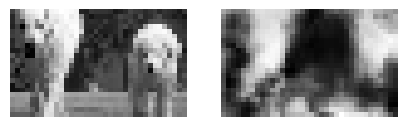

energy-scale=0.8  DM-loss-fn=MSE-no-standardization  DM-weight=0.001  EM-weight=1
[INFO] VGGPerceptualLoss: reduction=per_sample_mean_sum


  0%|          | 0/1000 [00:00<?, ?it/s]

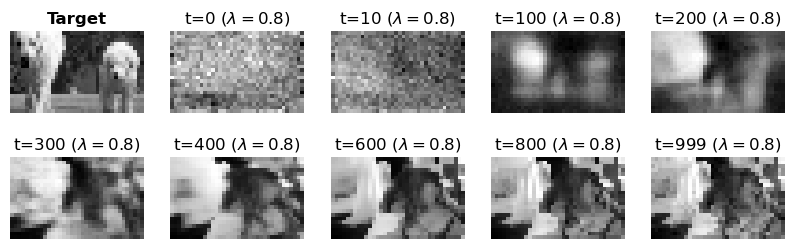

energy-scale=0.8  DM-loss-fn=MSE-no-standardization  DM-weight=0.1  EM-weight=1
[INFO] VGGPerceptualLoss: reduction=per_sample_mean_sum


  0%|          | 0/1000 [00:00<?, ?it/s]

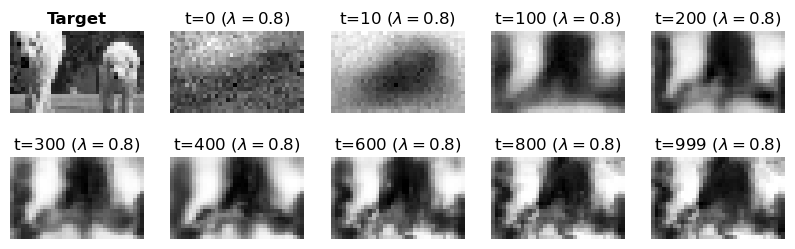

energy-scale=1.6  DM-loss-fn=MSE-no-standardization  DM-weight=0.001  EM-weight=1
[INFO] VGGPerceptualLoss: reduction=per_sample_mean_sum


  0%|          | 0/1000 [00:00<?, ?it/s]

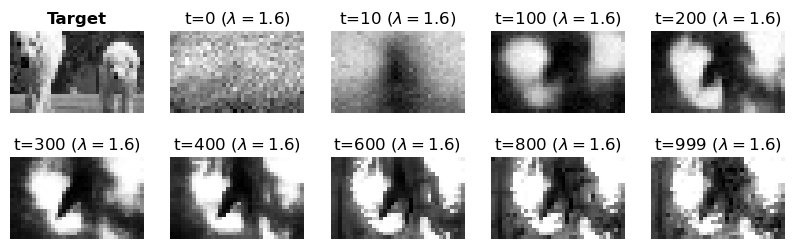

energy-scale=1.6  DM-loss-fn=MSE-no-standardization  DM-weight=0.1  EM-weight=1
[INFO] VGGPerceptualLoss: reduction=per_sample_mean_sum


  0%|          | 0/1000 [00:00<?, ?it/s]

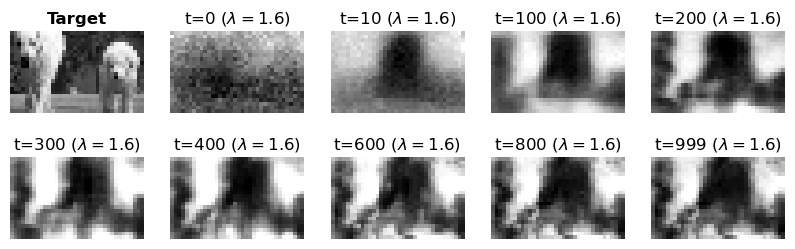

energy-scale=2.5  DM-loss-fn=MSE-no-standardization  DM-weight=0.001  EM-weight=1
[INFO] VGGPerceptualLoss: reduction=per_sample_mean_sum


  0%|          | 0/1000 [00:00<?, ?it/s]

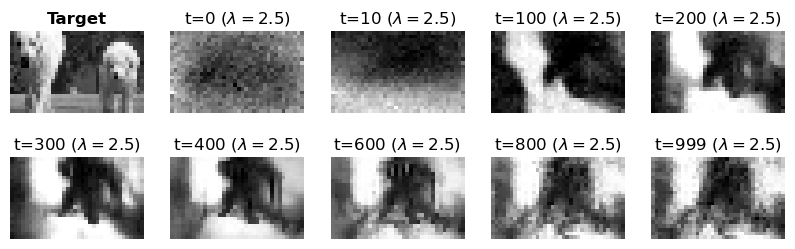

energy-scale=2.5  DM-loss-fn=MSE-no-standardization  DM-weight=0.1  EM-weight=1
[INFO] VGGPerceptualLoss: reduction=per_sample_mean_sum


  0%|          | 0/1000 [00:00<?, ?it/s]

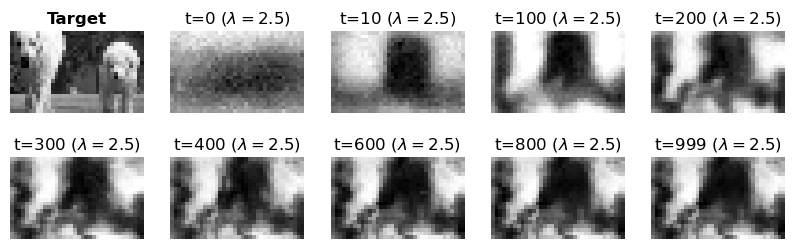

In [14]:
### plot
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(crop(target_image, config["crop_win"])[0].cpu().detach().permute(1,2,0).numpy(), "gray")
ax.axis("off")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(crop(stim_preds[0], config["crop_win"])[img_idx,0].cpu().numpy(), "gray")
ax.axis("off")
plt.show()

### run
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
random.seed(config["seed"])
for es in [0.8, 1.6, 2.5]:
    for em_w in [1]:
        for dm_w in [0.001, 0.1]:
            for dm_loss_fn_name in ["MSE-no-standardization"]:
                print(f"energy-scale={es}  DM-loss-fn={dm_loss_fn_name}  DM-weight={dm_w}  EM-weight={em_w}")
                _dm_loss_fn = get_metrics(crop_win=config["crop_win"], device=config["device"])[dm_loss_fn_name]
                score, image, imgs = do_run(
                    model=model,
                    energy_fn=partial(
                        energy_fn,
                        encoder_model=encoder_pred,
                        target_response=target_response,
                        norm=target_image.norm(),
                        em_weight=em_w,
                        dm_weight=dm_w,
                        dm_loss_fn=_dm_loss_fn,
                        xs_zero_to_match=[stim_pred[img_idx].unsqueeze(0) for stim_pred in stim_preds],
                    ),
                    energy_scale=es,
                    grayscale=True,
                )
                plot_diffusion(target_image, imgs, energy_scale=es)

In [ ]:
for t in [0, 5, 10, 100, 200, 300, 400, 500, 600, 800, 999]:
    fig = plt.figure(figsize=(5,2.5))
    
    ### gt
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(crop(target_image, config["crop_win"])[0].cpu().permute(1, 2, 0), "gray")
    ax.axis("off")
    
    # ax = fig.add_subplot(1, 4, 2)
    # ax.imshow(np.moveaxis(imgs[t], 0, 2), "gray")
    # ax.axis("off")

    ax = fig.add_subplot(1, 2, 2)
    tar = F.interpolate(
        torch.from_numpy(imgs[t]).unsqueeze(0), size=(36, 64), mode="bilinear", align_corners=False
    )[0]
    ax.imshow(tar.detach().permute(1,2,0).numpy(), "gray")
    ax.set_title(f"t={t}" + r" ($\lambda=$" + str(energy_scale) + ")")
    ax.axis("off")

    # ax = fig.add_subplot(1, 3, 3)
    # ax.imshow(np.moveaxis(crop(imgs[t], config["crop_win"]), 0, 2), "gray")
    # ax.axis("off")
    
    plt.show()

In [ ]:
fig = plt.figure(figsize=(3,2.5))
plt.imshow(crop(target_image, config["crop_win"])[0].cpu().detach().permute(1,2,0).numpy(), "gray")
plt.axis("off")
plt.show()

fig = plt.figure(figsize=(3,2.5))
plt.imshow(target_image[0].cpu().detach().permute(1,2,0).numpy(), "gray")
plt.axis("off")
plt.show()

plt.imshow(image.detach().permute(1,2,0).numpy(), "gray")
plt.axis("off")
plt.show()

tar = F.interpolate(
    image.unsqueeze(0), size=(36, 64), mode="bilinear", align_corners=False
)[0]
fig = plt.figure(figsize=(3,2.5))
plt.imshow(tar.detach().permute(1,2,0).numpy(), "gray")
plt.axis("off")
plt.show()

fig = plt.figure(figsize=(3,2.5))
plt.imshow(crop(image, config["crop_win"]).detach().permute(1,2,0).numpy(), "gray")
plt.axis("off")
plt.show()

## Decoder-encoder inversion

#### Data

In [ ]:
config["crop_win"] = (22, 36)
config["data"] = dict(mixing_strategy="sequential")

### mouse v1 data
config["data"]["mouse_v1"] = {
    "dataset_fn": "sensorium.datasets.static_loaders",
    "dataset_config": {
        "paths": [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
            # os.path.join(DATA_PATH, "static26872-17-20-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # mouse 1
            # os.path.join(DATA_PATH, "static27204-5-13-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # sensorium+ (mouse 2)
            os.path.join(DATA_PATH, "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 3)
            # os.path.join(DATA_PATH, "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 4)
            # os.path.join(DATA_PATH, "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 5)
            # os.path.join(DATA_PATH, "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 6)
            # os.path.join(DATA_PATH, "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 7)
        ],
        "normalize": True,
        "scale": 0.25, # 256x144 -> 64x36
        "include_behavior": False,
        "add_behavior_as_channels": False,
        "include_eye_position": True,
        "exclude": None,
        "file_tree": True,
        "cuda": "cuda" in config["device"],
        "batch_size": 8,
        "seed": config["seed"],
        "use_cache": False,
    },
    "skip_train": False,
    "skip_val": False,
    "skip_test": False,
    "normalize_neuron_coords": True,
    "average_test_multitrial": True,
    "save_test_multitrial": True,
    "test_batch_size": 7,
    "device": config["device"],
}

### sample data
dls, neuron_coords = get_all_data(config=config)
sample_data_key = dls["mouse_v1"]["val"].data_keys[0]
datapoint = next(iter(dls["mouse_v1"]["val"].dataloaders[0]))
stim, resp, pupil_center = datapoint.images, datapoint.responses, datapoint.pupil_center

#### Modeling

In [ ]:
### setup
import os
import random
import sys
from functools import partial
import torch.nn.functional as F
import torchvision.models as torch_models
from PIL import Image
from torch import nn
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm import tqdm
from scipy import signal

class GaussianBlur:
    """Blur an image with a Gaussian window.
    Arguments:
        sigma (float or tuple): Standard deviation in y, x used for the gaussian blurring.
        decay_factor (float): Compute sigma every iteration as `sigma + decay_factor *
            (iteration - 1)`. Ignored if None.
        truncate (float): Gaussian window is truncated after this number of standard
            deviations to each side. Size of kernel = 8 * sigma + 1
        pad_mode (string): Mode for the padding used for the blurring. Valid values are:
            'constant', 'reflect' and 'replicate'
        mei_only (True/False): for transparent mei, if True, no Gaussian blur for transparent channel:
            default should be False (also for non transparent case)
    """

    def __init__(
        self, sigma, decay_factor=None, truncate=4, pad_mode="reflect", mei_only=False
    ):
        self.sigma = sigma if isinstance(sigma, tuple) else (sigma,) * 2
        self.decay_factor = decay_factor
        self.truncate = truncate
        self.pad_mode = pad_mode
        self.mei_only = mei_only

    def __call__(self, x, iteration=None):

        # Update sigma if needed
        if self.decay_factor is None:
            sigma = self.sigma
        else:
            sigma = tuple(s + self.decay_factor * (iteration - 1) for s in self.sigma)

        # Define 1-d kernels to use for blurring
        y_halfsize = max(int(round(sigma[0] * self.truncate)), 1)
        y_gaussian = signal.gaussian(2 * y_halfsize + 1, std=sigma[0])
        x_halfsize = max(int(round(sigma[1] * self.truncate)), 1)
        x_gaussian = signal.gaussian(2 * x_halfsize + 1, std=sigma[1])
        y_gaussian = torch.as_tensor(y_gaussian, device=x.device, dtype=x.dtype)
        x_gaussian = torch.as_tensor(x_gaussian, device=x.device, dtype=x.dtype)

        # Blur
        if self.mei_only:
            num_channels = x.shape[1] - 1
            padded_x = F.pad(
                x[:, :-1, ...],
                pad=(x_halfsize, x_halfsize, y_halfsize, y_halfsize),
                mode=self.pad_mode,
            )
        else:  # also blur transparent channel
            num_channels = x.shape[1]
            padded_x = F.pad(
                x,
                pad=(x_halfsize, x_halfsize, y_halfsize, y_halfsize),
                mode=self.pad_mode,
            )
        blurred_x = F.conv2d(
            padded_x,
            y_gaussian.repeat(num_channels, 1, 1)[..., None],
            groups=num_channels,
        )
        blurred_x = F.conv2d(
            blurred_x, x_gaussian.repeat(num_channels, 1, 1, 1), groups=num_channels
        )
        final_x = blurred_x / (y_gaussian.sum() * x_gaussian.sum())  # normalize
        # print(final_x.shape)
        if self.mei_only:
            return torch.cat(
                (final_x, x[:, -1, ...].view(x.shape[0], 1, x.shape[2], x.shape[3])),
                dim=1,
            )
        else:
            return final_x

In [ ]:
class ImageGen(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.image = torch.nn.Parameter(torch.randn_like(stim[0]).unsqueeze(0).to(config["device"]))

    def forward(self):
        return self.image

In [ ]:
### load decoder(s) and get reconstructions
decoder_paths = [
    os.path.join(DATA_PATH, "models", "gan", "2024-05-19_22-13-01", "ckpt/decoder_141.pt"),
    # os.path.join(DATA_PATH, "models", "gan", "2024-04-12_11-19-16", "ckpt/decoder_40.pt"),
    # os.path.join(DATA_PATH, "models", "cnn", "2024-05-21_22-22-25", "decoder.pt"),
    # os.path.join(DATA_PATH, "models", "cnn", "2024-05-24_14-28-56", "decoder.pt"),
]

decoder_predictions = []
for decoder_ckpt_path in decoder_paths:
    decoder, _ = load_decoder_from_ckpt(
        ckpt_path=decoder_ckpt_path,
        load_best=False,
        device=config["device"],
    )
    decoder_predictions.append(
        crop(decoder(
            resp,
            data_key=sample_data_key,
            pupil_center=pupil_center,
            neuron_coords=neuron_coords[sample_data_key]
        ), config["crop_win"]).detach()
    )

In [ ]:
encoder = get_encoder(
    ckpt_path=os.path.join(DATA_PATH, "models", "encoder_sens22_mall_mean_activity.pth"),
    device=config["device"],
    eval_mode=True,
)

In [ ]:
def energy_fn(
    stim_pred,
    target_response,
    decoder_predictions,
    em_weight=1,
    dm_weight=1,
    odm_weight=1,
    dm_loss_fn=F.mse_loss,
    decoders=None,
):
    energy = 0
    
    ### encoder response matching
    res = encoder(stim_pred, data_key=sample_data_key, pupil_center=target_pupil_center)
    energy += em_weight * torch.mean((res - target_response) ** 2)

    ### decoder stimulus matching
    if decoder_predictions is not None:
        for decoder_stim_pred in decoder_predictions:
            energy += dm_weight * dm_loss_fn(crop(stim_pred, config["crop_win"]), crop(decoder_stim_pred, config["crop_win"]))

    ### online decoder matching
    if decoders is not None:
        for decoder, decoder_gt_stim_pred in zip(decoders, decoder_predictions):
            decoder_recon_stim_pred = crop(decoder(
                res,
                data_key=sample_data_key,
                pupil_center=target_pupil_center,
                neuron_coords=neuron_coords[sample_data_key]
            ), config["crop_win"])
            energy += odm_weight * dm_loss_fn(crop(decoder_recon_stim_pred, config["crop_win"]), crop(decoder_gt_stim_pred, config["crop_win"]))


    return energy

In [ ]:
### config
img_idx = 3
target_response = resp[img_idx].to(config["device"])
# target_response = encoder(stim[img_idx].unsqueeze(0), data_key=sample_data_key, pupil_center=pupil_center[img_idx].unsqueeze(0))[0].to(config["device"])
target_image = stim[img_idx].to(config["device"])
target_pupil_center = pupil_center[img_idx].unsqueeze(0).to(config["device"])
target_decoder_predictions = [decoder_prediction[img_idx].unsqueeze(0) for decoder_prediction in decoder_predictions]

gaussian_blur = GaussianBlur(sigma=1.)
dm_loss_fn = get_metrics(crop_win=config["crop_win"], device=config["device"])["SSIML-PL"]
lr = 0.05
em_weight = 2
dm_weight = 0.1
odm_weight = 0.
# decoders = [decoder]
decoders = None

fig = plt.figure(figsize=(3,2))
plt.imshow(crop(target_image, config["crop_win"])[0].cpu().detach().numpy(), "gray")
plt.axis("off")
plt.show()

fig = plt.figure(figsize=(3,2))
plt.imshow(crop(decoder_predictions[0], config["crop_win"])[img_idx,0].cpu().detach().numpy(), "gray")
plt.axis("off")
plt.show()

In [ ]:
### run
image_gen = ImageGen().to(config["device"])
opter = torch.optim.AdamW(image_gen.parameters(), lr=lr)

img_history = dict()
pbar = tqdm(range(5000))
for i in pbar:
    stim_pred = image_gen()
    stim_pred = gaussian_blur(stim_pred)
    stim_pred = stim_pred / torch.norm(stim_pred) * 30 #target_image.norm()  # 60

    energy = energy_fn(
        stim_pred=stim_pred,
        target_response=target_response,
        decoder_predictions=target_decoder_predictions,
        em_weight=em_weight,
        dm_weight=dm_weight,
        dm_loss_fn=dm_loss_fn,
        odm_weight=odm_weight,
        decoders=decoders,
    )

    energy.backward(retain_graph=True)
    opter.step()
    opter.zero_grad()

    pbar.set_description(
        f"energy: {energy.item()}"
    )

    if i % 50 == 0:
        img_history[i] = stim_pred.detach().clone().cpu()
    
    if i % 300 == 0:
        fig = plt.figure(figsize=(3,2))
        plt.imshow(crop(stim_pred, config["crop_win"])[0,0].cpu().detach().numpy(), "gray")
        plt.axis("off")
        plt.show()

In [ ]:
### plot progression in one plot
fig = plt.figure(figsize=(10, 3))

### gt
ax = fig.add_subplot(2, 5, 1)
ax.imshow(crop(target_image, config["crop_win"])[0].cpu(), "gray")
ax.axis("off")
ax.set_title(f"Target", fontweight="bold")

for t_idx, t in enumerate([0, 50, 100, 150, 200, 500, 1000, 2000, 4500]):
    ax = fig.add_subplot(2, 5, t_idx + 2)
    ax.imshow(crop(img_history[t], config["crop_win"])[0,0].numpy(), "gray")
    ax.set_title(f"t={t}")
    ax.axis("off")

plt.show()